# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [36]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [37]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3450, 4)

<Axes: ylabel='Date'>

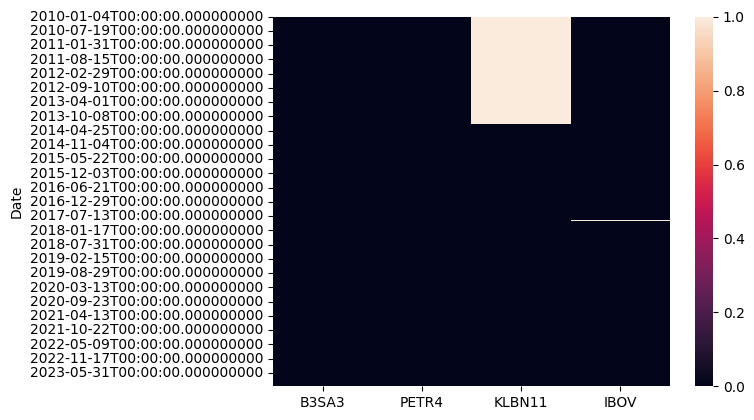

In [38]:
sns.heatmap(acoes_df.isnull())

In [39]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2023-11-22,13.020000,35.160000,23.410000,126035.0
2023-11-23,13.170000,35.169998,23.340000,126576.0
2023-11-24,12.920000,35.270000,22.950001,125542.0


### Visualização dos dados 

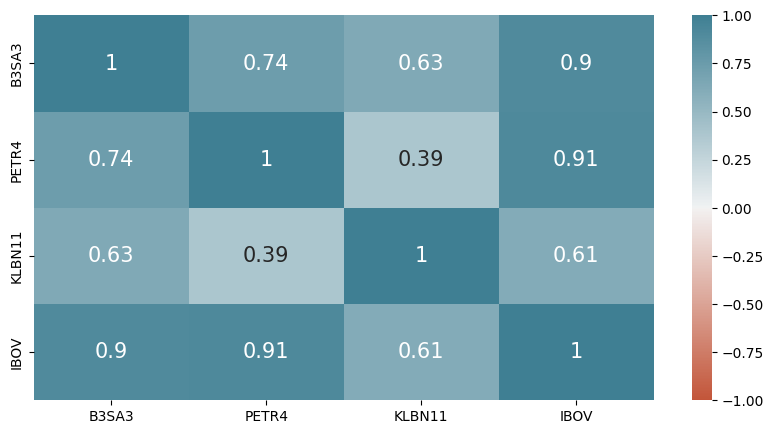

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [41]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [42]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2023-11-22,4.006154,2.272786,1.993358,2.608286
2023-11-23,4.052308,2.273432,1.987398,2.619482
2023-11-24,3.975385,2.279897,1.954189,2.598084


In [43]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [44]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [45]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [46]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [47]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


[*********************100%%**********************]  1 of 1 completed


In [48]:
df.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2023-11-14', '2023-11-16', '2023-11-17', '2023-11-20',
               '2023-11-21', '2023-11-22', '2023-11-23', '2023-11-24',
               '2023-11-27', '2023-11-28'],
              dtype='datetime64[ns]', name='Date', length=2207, freq=None)

In [49]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA9,EMA20,EMA50,EMA100,EMA200,Variacao,Subida,weekday,day,month,quarter
0,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,48512.000000,48512.000000,48512.000000,48512.000000,48512.000000,-0.968832,0,5,2,1,1
1,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,47959.222222,47989.625000,48004.550000,48009.525000,48012.012500,0.271482,0,1,5,1,1
2,2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,47976.344262,47993.801832,48003.319024,48006.626312,48008.304897,0.052082,0,2,6,1,1
3,2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,48479.953930,48417.936627,48390.420466,48381.714620,48377.451872,-0.901684,0,3,7,1,1
4,2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,48915.177059,48786.836479,48726.264184,48706.585611,48696.854843,-4.374987,0,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,2023-11-22,125626.0,126875.0,125439.0,126035.0,126035.0,14058500,123580.288118,120683.740580,118217.491345,116750.080340,114617.490064,0.000000,0,3,22,11,4
2203,2023-11-23,126035.0,126760.0,125764.0,126576.0,126576.0,7816400,124179.430494,121244.908144,118545.275998,116944.653007,114736.480213,0.000000,0,4,23,11,4
2204,2023-11-24,126553.0,126553.0,125341.0,125542.0,125542.0,9613100,124451.944395,121654.154987,118819.657331,117114.897501,114843.997823,0.000000,0,5,24,11,4
2205,2023-11-27,125517.0,125826.0,124840.0,125683.0,125683.0,11013800,124698.155516,122037.854512,119088.808024,117284.562897,114951.848591,0.000000,0,1,27,11,4


## Tratamento de dados para Predição de ativos

### Pré-processamento dos dados para predição 

In [50]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
ticker='IBOV'
acoes_df = acoes_df[['Date', 'IBOV']]
acoes_df.columns = ['ds', 'y']

In [51]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [52]:
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.vstack(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2416, 23)
y shape (2416, 1)
Last Date 2023-11-28T00:00:00.000000000


In [53]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    nit_test= np.max(X_train.shape) -1
    X_test=X[nit_test:,:]

    y_train=y[:nits]
    y_test =y[nit_test:]
    
    T_train=date_time[:nits]
    T_test =date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [54]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train, y=np.hstack(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.hstack(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

## Modelos de rede neural

### CNN_LSTM

In [88]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 10, 64)            384       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 5, 64)             0         
                                                                 
 flatten_6 (Flatten)         (None, 320)               0         
                                                                 
 dense_28 (Dense)            (None, 32)                10272     
                                                                 
 activation_12 (Activation)  (None, 32)                0         
                                                          

### MultiLayer Perceptron

In [89]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name=model_name
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_30 (Dense)            (None, 64)                1536      
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9985 (39.00 KB)
Trainable params: 9985 (39.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (LSTM) 

In [90]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, activation='relu', return_sequences=False)(input_data)
Dropout_output = Dropout(0.2)(lstm_output)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 23, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (GRU) 

In [91]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64, activation='relu')(input_data)
Dropout_output = Dropout(0.2)(GRU_output)
output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 23, 1)]           0         


                                                                 
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM with Attention layer

In [92]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [93]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_data)
x = Dropout(0.2)(x)
x = Attention(64)(x)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 23, 1)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 23, 64)            16896     
                                                                 
 dropout_18 (Dropout)        (None, 23, 64)            0         
                                                                 
 attention_2 (Attention)     (None, 64)                4225      
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21186 (82.76 KB)
Trainable params: 21186 (82.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparâmetros para de treinamento

**Metrics and Loss Functions**  

In [94]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [95]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [96]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

Training model : models/model_MLP_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


40/45 [=========================>....] - ETA: 0s - loss: 1.3237 - NRMSE: 0.6329
Epoch 1: val_loss improved from inf to 0.00706, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 7s 76ms/step - loss: 1.1809 - NRMSE: 0.6596 - val_loss: 0.0071 - val_NRMSE: 0.9206 - lr: 0.0500
Epoch 2/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0101 - NRMSE: 0.9008
Epoch 2: val_loss did not improve from 0.00706
45/45 [==============================] - 0s 5ms/step - loss: 0.0100 - NRMSE: 0.9017 - val_loss: 0.0079 - val_NRMSE: 0.9142 - lr: 0.0500
Epoch 3/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0080 - NRMSE: 0.9124
Epoch 3: val_loss improved from 0.00706 to 0.00239, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 5s 109ms/step - loss: 0.0080 - NRMSE: 0.9127 - val_loss: 0.0024 - val_NRMSE: 0.9570 - lr: 0.0500
Epoch 4/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0066 - NRMSE: 0.9201
Epoch 4: val_loss did not improve from 0.00239
45/45 [==============================] - 1s 11ms/step - loss: 0.0068 - NRMSE: 0.9192 - val_loss: 0.0024 - val_NRMSE: 0.9558 - lr: 0.0500
Epoch 5/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0052 - NRMSE: 0.9293
Epoch 5: val_loss did not improve from 0.00239
45/45 [==============================] - 1s 16ms/step - loss: 0.0051 - NRMSE: 0.9304 - val_loss: 0.0118 - val_NRMSE: 0.8955 - lr: 0.0500
Epoch 6/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9351
Epoch 6: val_loss improved from 0.00239 to 0.00191, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 5s 116ms/step - loss: 0.0045 - NRMSE: 0.9351 - val_loss: 0.0019 - val_NRMSE: 0.9634 - lr: 0.0500
Epoch 7/200
36/45 [=======================>......] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9445
Epoch 7: val_loss did not improve from 0.00191
45/45 [==============================] - 0s 9ms/step - loss: 0.0032 - NRMSE: 0.9454 - val_loss: 0.0025 - val_NRMSE: 0.9535 - lr: 0.0500
Epoch 8/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9454
Epoch 8: val_loss did not improve from 0.00191
45/45 [==============================] - 0s 8ms/step - loss: 0.0031 - NRMSE: 0.9458 - val_loss: 0.0033 - val_NRMSE: 0.9476 - lr: 0.0500
Epoch 9/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9481
Epoch 9: val_loss improved from 0.00191 to 0.00155, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 3s 67ms/step - loss: 0.0028 - NRMSE: 0.9484 - val_loss: 0.0015 - val_NRMSE: 0.9647 - lr: 0.0500
Epoch 10/200
37/45 [=======================>......] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9456
Epoch 10: val_loss did not improve from 0.00155
45/45 [==============================] - 0s 10ms/step - loss: 0.0029 - NRMSE: 0.9475 - val_loss: 0.0019 - val_NRMSE: 0.9602 - lr: 0.0500
Epoch 11/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9516
Epoch 11: val_loss did not improve from 0.00155
45/45 [==============================] - 0s 7ms/step - loss: 0.0025 - NRMSE: 0.9511 - val_loss: 0.0030 - val_NRMSE: 0.9494 - lr: 0.0500
Epoch 12/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9515
Epoch 12: val_loss did not improve from 0.00155
45/45 [==============================] - 0s 8ms/step - loss: 0.0024 - NRMSE: 0.9518 - val_loss: 0.0016 - val_NRMSE: 0.9638 - lr: 0.0500
Epoch 13/200
18/45 [===========

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 1s 27ms/step - loss: 0.0020 - NRMSE: 0.9568 - val_loss: 0.0013 - val_NRMSE: 0.9673 - lr: 0.0100
Epoch 16/200
28/45 [=================>............] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9591
Epoch 16: val_loss improved from 0.00133 to 0.00117, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 1s 30ms/step - loss: 0.0017 - NRMSE: 0.9591 - val_loss: 0.0012 - val_NRMSE: 0.9702 - lr: 0.0100
Epoch 17/200
20/45 [============>.................] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9564
Epoch 17: val_loss did not improve from 0.00117
45/45 [==============================] - 0s 4ms/step - loss: 0.0018 - NRMSE: 0.9585 - val_loss: 0.0023 - val_NRMSE: 0.9540 - lr: 0.0100
Epoch 18/200
31/45 [===================>..........] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9573
Epoch 18: val_loss did not improve from 0.00117
45/45 [==============================] - 0s 4ms/step - loss: 0.0019 - NRMSE: 0.9579 - val_loss: 0.0012 - val_NRMSE: 0.9700 - lr: 0.0100
Epoch 19/200
25/45 [===============>..............] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9578
Epoch 19: val_loss did not improve from 0.00117
45/45 [==============================] - 0s 4ms/step - loss: 0.0018 - NRMSE: 0.9587 - val_loss: 0.0012 - val_NRMSE: 0.9682 - lr: 0.0100
Epoch 20/200
30/45 [============

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 1s 31ms/step - loss: 0.0017 - NRMSE: 0.9597 - val_loss: 0.0011 - val_NRMSE: 0.9713 - lr: 0.0100
Epoch 22/200
27/45 [=================>............] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9605
Epoch 22: val_loss did not improve from 0.00107
45/45 [==============================] - 0s 4ms/step - loss: 0.0016 - NRMSE: 0.9607 - val_loss: 0.0011 - val_NRMSE: 0.9705 - lr: 0.0020
Epoch 23/200
29/45 [==================>...........] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9587
Epoch 23: val_loss did not improve from 0.00107
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - NRMSE: 0.9588 - val_loss: 0.0011 - val_NRMSE: 0.9698 - lr: 0.0020
Epoch 24/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9603   
Epoch 24: val_loss did not improve from 0.00107
45/45 [==============================] - 0s 5ms/step - loss: 0.0017 - NRMSE: 0.9596 - val_loss: 0.0018 - val_NRMSE: 0.9599 - lr: 0.0020
Epoch 25/200
23/45 [=========

INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 1s 30ms/step - loss: 0.0017 - NRMSE: 0.9595 - val_loss: 0.0011 - val_NRMSE: 0.9713 - lr: 0.0020
Epoch 26/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9592
Epoch 26: val_loss did not improve from 0.00106
45/45 [==============================] - 0s 7ms/step - loss: 0.0017 - NRMSE: 0.9597 - val_loss: 0.0011 - val_NRMSE: 0.9707 - lr: 0.0020
Epoch 27/200
28/45 [=================>............] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9609
Epoch 27: val_loss did not improve from 0.00106
45/45 [==============================] - 0s 7ms/step - loss: 0.0018 - NRMSE: 0.9589 - val_loss: 0.0013 - val_NRMSE: 0.9666 - lr: 0.0020
Epoch 28/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9586
Epoch 28: val_loss improved from 0.00106 to 0.00105, saving model to models\model_MLP_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_MLP_stock_IBOV_lookback_23\assets


45/45 [==============================] - 2s 35ms/step - loss: 0.0018 - NRMSE: 0.9590 - val_loss: 0.0011 - val_NRMSE: 0.9716 - lr: 0.0020
Epoch 29/200
32/45 [====================>.........] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9584
Epoch 29: val_loss did not improve from 0.00105
45/45 [==============================] - 0s 5ms/step - loss: 0.0017 - NRMSE: 0.9599 - val_loss: 0.0012 - val_NRMSE: 0.9686 - lr: 0.0020
Epoch 30/200
28/45 [=================>............] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9595
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 30: val_loss did not improve from 0.00105
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - NRMSE: 0.9578 - val_loss: 0.0012 - val_NRMSE: 0.9692 - lr: 0.0020
Epoch 31/200
33/45 [=====================>........] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9602
Epoch 31: val_loss did not improve from 0.00105
45/45 [==============================] - 0s 5ms/step - loss: 0.0016 - NRMSE: 0.9603 - val_

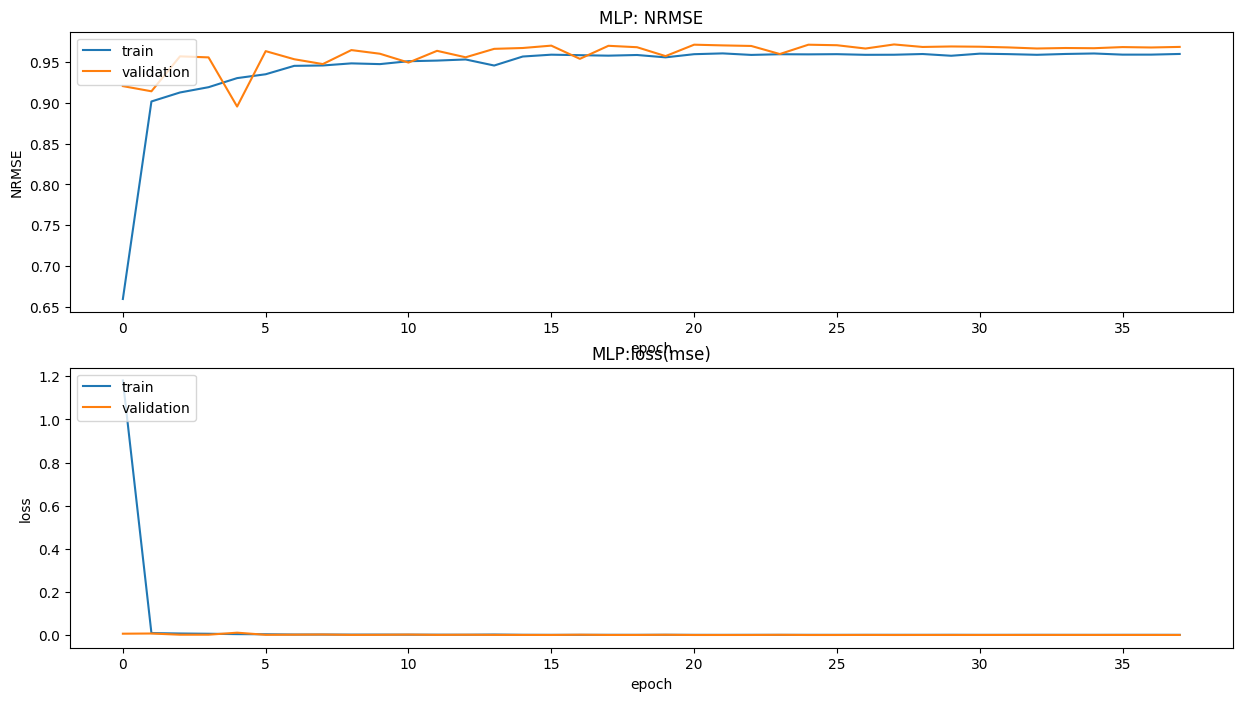

Training model : models/model_GRU_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
44/45 [============================>.] - ETA: 0s - loss: 0.0093 - NRMSE: 0.9269
Epoch 1: val_loss improved from inf to 0.00046, saving model to models\model_GRU_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


45/45 [==============================] - 14s 217ms/step - loss: 0.0091 - NRMSE: 0.9273 - val_loss: 4.6372e-04 - val_NRMSE: 0.9804 - lr: 0.0500
Epoch 2/200
44/45 [============================>.] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9608
Epoch 2: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 18ms/step - loss: 0.0016 - NRMSE: 0.9608 - val_loss: 0.0011 - val_NRMSE: 0.9686 - lr: 0.0500
Epoch 3/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9610
Epoch 3: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 16ms/step - loss: 0.0017 - NRMSE: 0.9604 - val_loss: 6.0550e-04 - val_NRMSE: 0.9770 - lr: 0.0500
Epoch 4/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9562
Epoch 4: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 16ms/step - loss: 0.0020 - NRMSE: 0.9564 - val_loss: 6.9853e-04 - val_NRMSE: 0.9756 - lr: 0.0500
Epoch 5/200
44/45 [==

INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


45/45 [==============================] - 9s 197ms/step - loss: 0.0015 - NRMSE: 0.9621 - val_loss: 4.5676e-04 - val_NRMSE: 0.9809 - lr: 0.0500
Epoch 6/200
44/45 [============================>.] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9637
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 6: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 16ms/step - loss: 0.0014 - NRMSE: 0.9636 - val_loss: 8.1311e-04 - val_NRMSE: 0.9731 - lr: 0.0500
Epoch 7/200
44/45 [============================>.] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9620
Epoch 7: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 16ms/step - loss: 0.0015 - NRMSE: 0.9622 - val_loss: 5.0807e-04 - val_NRMSE: 0.9796 - lr: 0.0100
Epoch 8/200
44/45 [============================>.] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9658
Epoch 8: val_loss did not improve from 0.00046
45/45 [==============================] - 1s 20ms/step - loss: 0.0012 - NRMSE: 0.965

INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 98ms/step - loss: 0.0011 - NRMSE: 0.9672 - val_loss: 4.5226e-04 - val_NRMSE: 0.9810 - lr: 0.0020
Epoch 15/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9675
Epoch 15: val_loss improved from 0.00045 to 0.00045, saving model to models\model_GRU_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_GRU_stock_IBOV_lookback_23\assets


45/45 [==============================] - 6s 125ms/step - loss: 0.0011 - NRMSE: 0.9670 - val_loss: 4.4901e-04 - val_NRMSE: 0.9811 - lr: 0.0020
Epoch 16/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9668
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 16: val_loss did not improve from 0.00045
45/45 [==============================] - 1s 15ms/step - loss: 0.0012 - NRMSE: 0.9666 - val_loss: 4.6245e-04 - val_NRMSE: 0.9807 - lr: 0.0020
Epoch 17/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9674
Epoch 17: val_loss did not improve from 0.00045
45/45 [==============================] - 1s 15ms/step - loss: 0.0011 - NRMSE: 0.9675 - val_loss: 4.7168e-04 - val_NRMSE: 0.9804 - lr: 4.0000e-04
Epoch 18/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9679
Epoch 18: val_loss did not improve from 0.00045
45/45 [==============================] - 1s 14ms/step - loss: 0.0011 - 

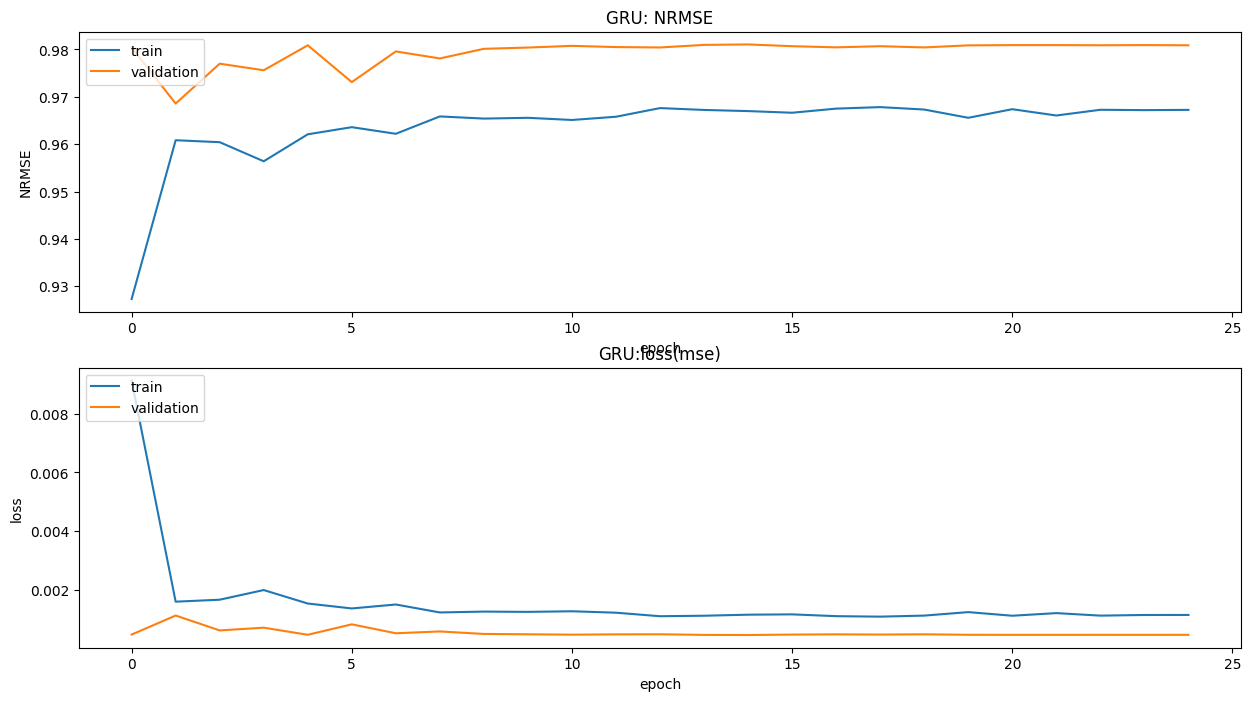

Training model : models/model_CNN_LSTM_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
37/45 [=======================>......] - ETA: 0s - loss: 2.8587 - NRMSE: 0.5016 
Epoch 1: val_loss improved from inf to 0.00681, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 52ms/step - loss: 2.3561 - NRMSE: 0.5794 - val_loss: 0.0068 - val_NRMSE: 0.9323 - lr: 0.0500
Epoch 2/200
33/45 [=====================>........] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9408
Epoch 2: val_loss improved from 0.00681 to 0.00501, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 2s 54ms/step - loss: 0.0036 - NRMSE: 0.9409 - val_loss: 0.0050 - val_NRMSE: 0.9434 - lr: 0.0500
Epoch 3/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9489
Epoch 3: val_loss did not improve from 0.00501
45/45 [==============================] - 0s 9ms/step - loss: 0.0026 - NRMSE: 0.9494 - val_loss: 0.0060 - val_NRMSE: 0.9367 - lr: 0.0500
Epoch 4/200
32/45 [====================>.........] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9515
Epoch 4: val_loss improved from 0.00501 to 0.00493, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 5s 120ms/step - loss: 0.0023 - NRMSE: 0.9519 - val_loss: 0.0049 - val_NRMSE: 0.9434 - lr: 0.0500
Epoch 5/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9541
Epoch 5: val_loss improved from 0.00493 to 0.00392, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 81ms/step - loss: 0.0021 - NRMSE: 0.9543 - val_loss: 0.0039 - val_NRMSE: 0.9498 - lr: 0.0500
Epoch 6/200
44/45 [============================>.] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9537
Epoch 6: val_loss did not improve from 0.00392
45/45 [==============================] - 0s 9ms/step - loss: 0.0022 - NRMSE: 0.9538 - val_loss: 0.0041 - val_NRMSE: 0.9485 - lr: 0.0500
Epoch 7/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9583
Epoch 7: val_loss improved from 0.00392 to 0.00376, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 2s 55ms/step - loss: 0.0018 - NRMSE: 0.9583 - val_loss: 0.0038 - val_NRMSE: 0.9511 - lr: 0.0500
Epoch 8/200
38/45 [========================>.....] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9576  
Epoch 8: val_loss did not improve from 0.00376
45/45 [==============================] - 0s 8ms/step - loss: 0.0017 - NRMSE: 0.9590 - val_loss: 0.0050 - val_NRMSE: 0.9405 - lr: 0.0500
Epoch 9/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9607
Epoch 9: val_loss improved from 0.00376 to 0.00352, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 3s 66ms/step - loss: 0.0016 - NRMSE: 0.9610 - val_loss: 0.0035 - val_NRMSE: 0.9523 - lr: 0.0500
Epoch 10/200
35/45 [======================>.......] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9601  
Epoch 10: val_loss did not improve from 0.00352
45/45 [==============================] - 0s 9ms/step - loss: 0.0018 - NRMSE: 0.9586 - val_loss: 0.0046 - val_NRMSE: 0.9439 - lr: 0.0500
Epoch 11/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9594
Epoch 11: val_loss did not improve from 0.00352
45/45 [==============================] - 0s 9ms/step - loss: 0.0017 - NRMSE: 0.9596 - val_loss: 0.0036 - val_NRMSE: 0.9520 - lr: 0.0500
Epoch 12/200
39/45 [=========================>....] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9632
Epoch 12: val_loss improved from 0.00352 to 0.00282, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 3s 58ms/step - loss: 0.0015 - NRMSE: 0.9620 - val_loss: 0.0028 - val_NRMSE: 0.9572 - lr: 0.0500
Epoch 13/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0013 - NRMSE: 0.9648
Epoch 13: val_loss did not improve from 0.00282
45/45 [==============================] - 0s 10ms/step - loss: 0.0013 - NRMSE: 0.9650 - val_loss: 0.0028 - val_NRMSE: 0.9559 - lr: 0.0500
Epoch 14/200
45/45 [==============================] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9623
Epoch 14: val_loss did not improve from 0.00282
45/45 [==============================] - 1s 12ms/step - loss: 0.0015 - NRMSE: 0.9623 - val_loss: 0.0060 - val_NRMSE: 0.9327 - lr: 0.0500
Epoch 15/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9662
Epoch 15: val_loss did not improve from 0.00282
45/45 [==============================] - 0s 10ms/step - loss: 0.0012 - NRMSE: 0.9661 - val_loss: 0.0043 - val_NRMSE: 0.9459 - lr: 0.0500
Epoch 16/200
45/45 [=========

INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 3s 68ms/step - loss: 0.0010 - NRMSE: 0.9685 - val_loss: 0.0026 - val_NRMSE: 0.9578 - lr: 0.0100
Epoch 22/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9668 
Epoch 22: val_loss did not improve from 0.00262
45/45 [==============================] - 0s 10ms/step - loss: 0.0011 - NRMSE: 0.9669 - val_loss: 0.0027 - val_NRMSE: 0.9564 - lr: 0.0100
Epoch 23/200
44/45 [============================>.] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9682  
Epoch 23: val_loss improved from 0.00262 to 0.00257, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 83ms/step - loss: 0.0010 - NRMSE: 0.9680 - val_loss: 0.0026 - val_NRMSE: 0.9589 - lr: 0.0100
Epoch 24/200
44/45 [============================>.] - ETA: 0s - loss: 9.5174e-04 - NRMSE: 0.9695
Epoch 24: val_loss did not improve from 0.00257
45/45 [==============================] - 0s 7ms/step - loss: 9.5381e-04 - NRMSE: 0.9694 - val_loss: 0.0027 - val_NRMSE: 0.9569 - lr: 0.0100
Epoch 25/200
37/45 [=======================>......] - ETA: 0s - loss: 9.8971e-04 - NRMSE: 0.9688
Epoch 25: val_loss improved from 0.00257 to 0.00255, saving model to models\model_CNN_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_CNN_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 90ms/step - loss: 0.0010 - NRMSE: 0.9686 - val_loss: 0.0025 - val_NRMSE: 0.9590 - lr: 0.0100
Epoch 26/200
36/45 [=======================>......] - ETA: 0s - loss: 9.5874e-04 - NRMSE: 0.9695
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 26: val_loss did not improve from 0.00255
45/45 [==============================] - 0s 6ms/step - loss: 9.7146e-04 - NRMSE: 0.9693 - val_loss: 0.0045 - val_NRMSE: 0.9431 - lr: 0.0100
Epoch 27/200
31/45 [===================>..........] - ETA: 0s - loss: 9.8585e-04 - NRMSE: 0.9690
Epoch 27: val_loss did not improve from 0.00255
45/45 [==============================] - 0s 6ms/step - loss: 9.5492e-04 - NRMSE: 0.9695 - val_loss: 0.0028 - val_NRMSE: 0.9576 - lr: 0.0020
Epoch 28/200
32/45 [====================>.........] - ETA: 0s - loss: 9.6708e-04 - NRMSE: 0.9693
Epoch 28: val_loss did not improve from 0.00255
45/45 [==============================] - 0s 5ms/step - loss: 9.6810e-0

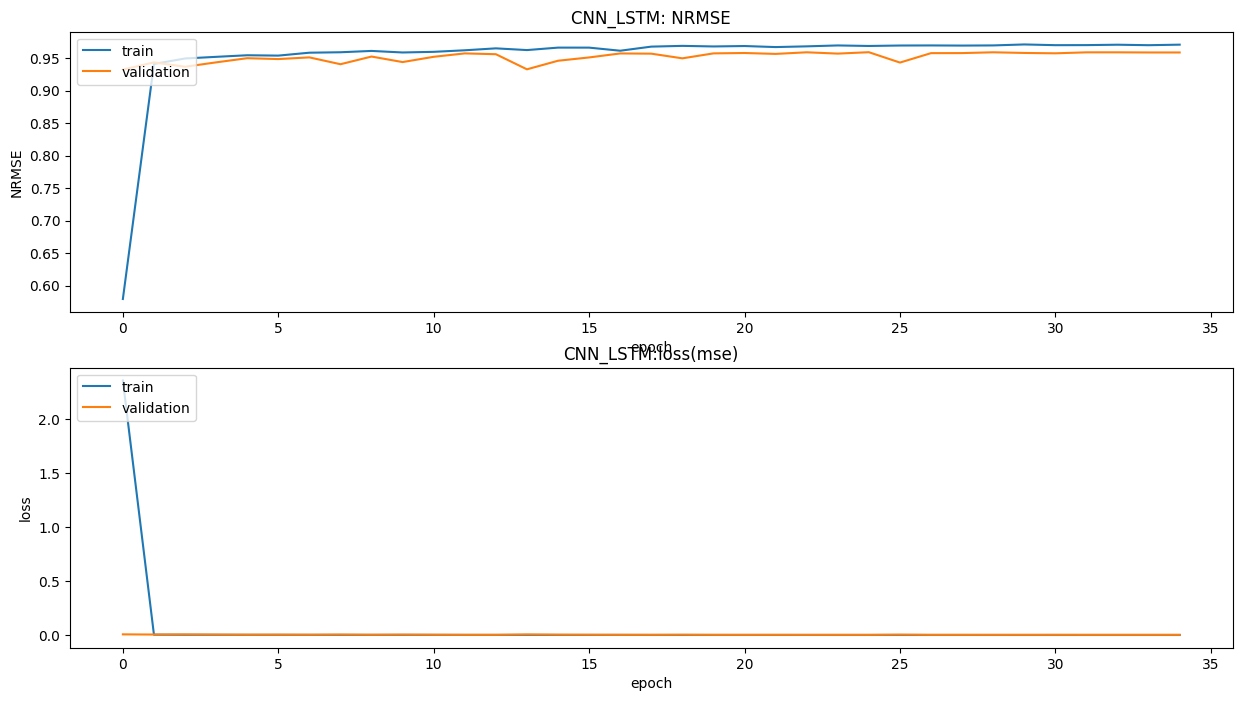

Training model : models/model_LSTM_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 569993472.0000 - NRMSE: -3556.4475
Epoch 1: val_loss improved from inf to 0.31590, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 10s 121ms/step - loss: 569993472.0000 - NRMSE: -3556.4475 - val_loss: 0.3159 - val_NRMSE: 0.4481 - lr: 0.0500
Epoch 2/200
44/45 [============================>.] - ETA: 0s - loss: 0.0730 - NRMSE: 0.7347
Epoch 2: val_loss improved from 0.31590 to 0.06282, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 101ms/step - loss: 0.0724 - NRMSE: 0.7360 - val_loss: 0.0628 - val_NRMSE: 0.7539 - lr: 0.0500
Epoch 3/200
42/45 [===========================>..] - ETA: 0s - loss: 0.0610 - NRMSE: 0.7577
Epoch 3: val_loss did not improve from 0.06282
45/45 [==============================] - 2s 43ms/step - loss: 0.0600 - NRMSE: 0.7601 - val_loss: 0.0856 - val_NRMSE: 0.7125 - lr: 0.0500
Epoch 4/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0481 - NRMSE: 0.7864
Epoch 4: val_loss improved from 0.06282 to 0.01923, saving model to models\model_LSTM_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_stock_IBOV_lookback_23\assets


45/45 [==============================] - 3s 76ms/step - loss: 0.0479 - NRMSE: 0.7870 - val_loss: 0.0192 - val_NRMSE: 0.8654 - lr: 0.0500
Epoch 5/200
41/45 [==========================>...] - ETA: 0s - loss: 0.0511 - NRMSE: 0.7784
Epoch 5: val_loss did not improve from 0.01923
45/45 [==============================] - 1s 15ms/step - loss: 0.0510 - NRMSE: 0.7785 - val_loss: 0.1685 - val_NRMSE: 0.5950 - lr: 0.0500
Epoch 6/200
40/45 [=========================>....] - ETA: 0s - loss: 0.0571 - NRMSE: 0.7649
Epoch 6: val_loss did not improve from 0.01923
45/45 [==============================] - 1s 16ms/step - loss: 0.0574 - NRMSE: 0.7638 - val_loss: 0.0469 - val_NRMSE: 0.7877 - lr: 0.0500
Epoch 7/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0445 - NRMSE: 0.7925
Epoch 7: val_loss did not improve from 0.01923
45/45 [==============================] - 1s 15ms/step - loss: 0.0448 - NRMSE: 0.7918 - val_loss: 0.0366 - val_NRMSE: 0.8143 - lr: 0.0500
Epoch 8/200
43/45 [================

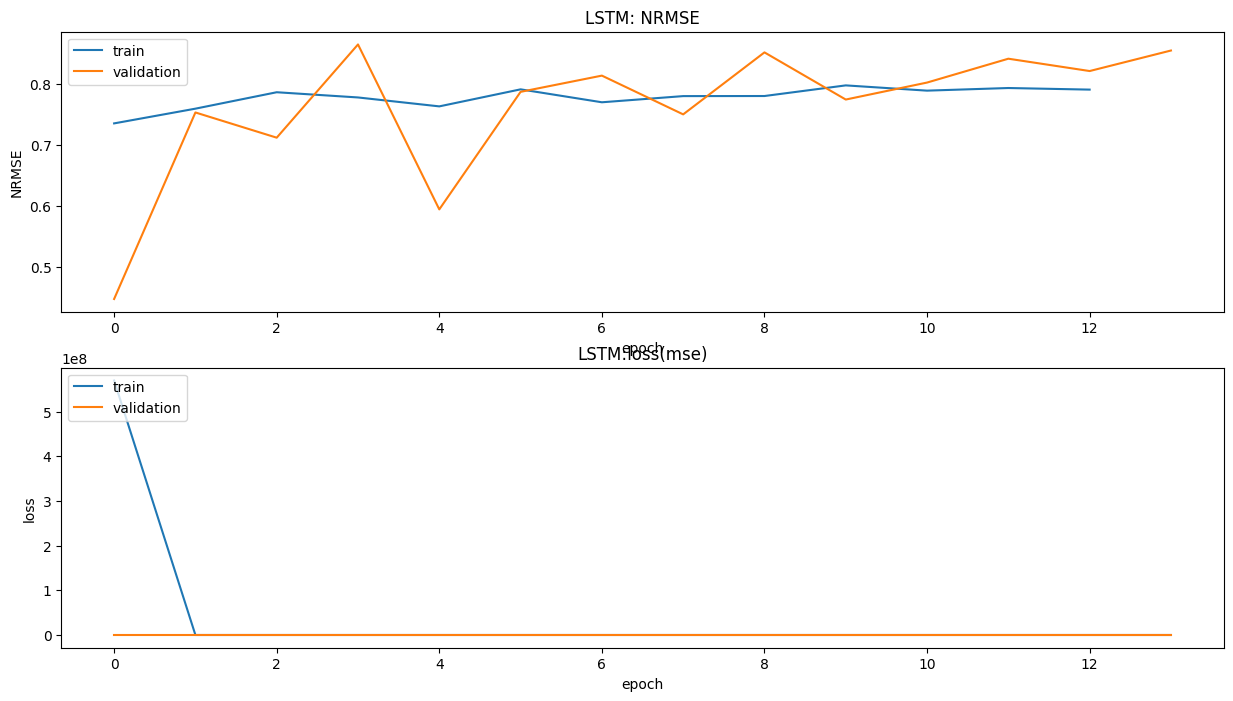

Training model : models/model_LSTM_AT_stock_IBOV_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
41/45 [==========================>...] - ETA: 0s - loss: 600710.3125 - NRMSE: -120.4378
Epoch 1: val_loss improved from inf to 0.08883, saving model to models\model_LSTM_AT_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


45/45 [==============================] - 6s 79ms/step - loss: 548456.4375 - NRMSE: -109.6494 - val_loss: 0.0888 - val_NRMSE: 0.7071 - lr: 0.0500
Epoch 2/200
44/45 [============================>.] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9591
Epoch 2: val_loss improved from 0.08883 to 0.04889, saving model to models\model_LSTM_AT_stock_IBOV_lookback_23
INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 85ms/step - loss: 0.0018 - NRMSE: 0.9594 - val_loss: 0.0489 - val_NRMSE: 0.7843 - lr: 0.0500
Epoch 3/200
41/45 [==========================>...] - ETA: 0s - loss: 9.6042e-04 - NRMSE: 0.9692
Epoch 3: val_loss did not improve from 0.04889
45/45 [==============================] - 1s 17ms/step - loss: 9.5124e-04 - NRMSE: 0.9694 - val_loss: 0.0592 - val_NRMSE: 0.7637 - lr: 0.0500
Epoch 4/200
45/45 [==============================] - ETA: 0s - loss: 0.0011 - NRMSE: 0.9677
Epoch 4: val_loss did not improve from 0.04889
45/45 [==============================] - 1s 17ms/step - loss: 0.0011 - NRMSE: 0.9677 - val_loss: 0.0619 - val_NRMSE: 0.7602 - lr: 0.0500
Epoch 5/200
44/45 [============================>.] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9684  
Epoch 5: val_loss did not improve from 0.04889
45/45 [==============================] - 1s 15ms/step - loss: 0.0010 - NRMSE: 0.9683 - val_loss: 0.0545 - val_NRMSE: 0.7743 - lr: 0.0500
Epoch 6/200
45/45 [======

INFO:tensorflow:Assets written to: models\model_LSTM_AT_stock_IBOV_lookback_23\assets


45/45 [==============================] - 4s 82ms/step - loss: 0.0011 - NRMSE: 0.9677 - val_loss: 0.0442 - val_NRMSE: 0.7965 - lr: 0.0500
Epoch 7/200
42/45 [===========================>..] - ETA: 0s - loss: 9.2076e-04 - NRMSE: 0.9700
Epoch 7: val_loss did not improve from 0.04424
45/45 [==============================] - 1s 16ms/step - loss: 9.3631e-04 - NRMSE: 0.9697 - val_loss: 0.0487 - val_NRMSE: 0.7867 - lr: 0.0500
Epoch 8/200
41/45 [==========================>...] - ETA: 0s - loss: 9.1871e-04 - NRMSE: 0.9699
Epoch 8: val_loss did not improve from 0.04424
45/45 [==============================] - 1s 14ms/step - loss: 9.2957e-04 - NRMSE: 0.9697 - val_loss: 0.0569 - val_NRMSE: 0.7684 - lr: 0.0500
Epoch 9/200
41/45 [==========================>...] - ETA: 0s - loss: 8.7186e-04 - NRMSE: 0.9706
Epoch 9: val_loss did not improve from 0.04424
45/45 [==============================] - 1s 14ms/step - loss: 8.5820e-04 - NRMSE: 0.9709 - val_loss: 0.0616 - val_NRMSE: 0.7589 - lr: 0.0500
Epoch 10/20

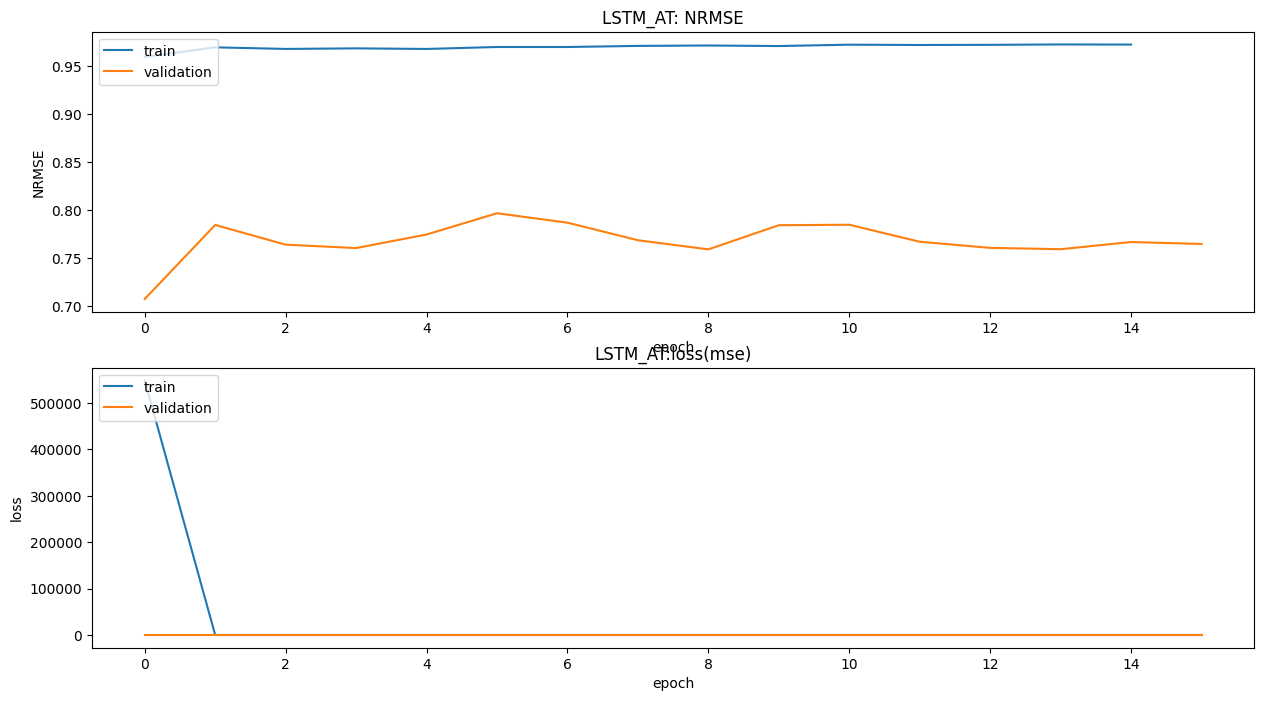

In [97]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

In [98]:
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [99]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x1dec8f66e30>,
 'GRU': <keras.src.engine.functional.Functional at 0x1dec45b8a90>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x1dec7d1ff10>,
 'LSTM': <keras.src.engine.functional.Functional at 0x1dec4598910>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x1dec67b2ec0>}

In [100]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df['y'].values)
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

12/12 [==============================] - 0s 1ms/step
MLP NN R2: 0.8886850401759148
12/12 [==============================] - 0s 4ms/step
GRU NN R2: 0.9545307643711567
12/12 [==============================] - 0s 1ms/step
CNN_LSTM NN R2: 0.7888627499341965
12/12 [==============================] - 0s 6ms/step
LSTM NN R2: -2.5905134677886963
12/12 [==============================] - 0s 9ms/step
LSTM_AT NN R2: -7.476520538330078


In [101]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [102]:
np.hstack(predictions)

array([107168.055, 101700.27 , 108839.09 , ..., 122489.734, 106239.94 ,
        97978.91 ], dtype=float32)

In [103]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [104]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [105]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2023-11-28
Estamos Fornecendo dados até o dia : 2023-11-27
O modelo fará previsões até o dia:  2023-12-04


In [106]:
X_test[:-dias_antes,:]

array([[0.744294  , 0.7583272 , 0.76428777, ..., 0.7288243 , 0.69791704,
        0.6921815 ],
       [0.7583272 , 0.76428777, 0.73703617, ..., 0.69791704, 0.6921815 ,
        0.7001576 ],
       [0.76428777, 0.73703617, 0.7451624 , ..., 0.6921815 , 0.7001576 ,
        0.668189  ],
       ...,
       [0.8201954 , 0.8110936 , 0.80712706, ..., 0.94981724, 0.9445856 ,
        0.949174  ],
       [0.8110936 , 0.80712706, 0.817601  , ..., 0.9445856 , 0.949174  ,
        0.95497376],
       [0.80712706, 0.817601  , 0.8076095 , ..., 0.949174  , 0.95497376,
        0.9438887 ]], dtype=float32)

In [107]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=4

    NN_predictions=y_test[:-dias_antes].copy()
    X_inputs=X_test[:-dias_antes,:].copy()
    T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    for k in range(n_steps):
        
        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 34ms/step


In [108]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
        model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
        model_arima_fit = model_arima.fit()

        arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
        arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
        arima_predictions.shape

Using ARIMA model


In [109]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [110]:
pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': NN_predictions})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(-1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.2 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
356,2023-11-20,0.949817,0.550803,1
357,2023-11-21,0.944586,-0.485754,0
358,2023-11-22,0.949174,-0.611033,0
359,2023-11-23,0.954974,1.160768,1
360,2023-11-24,0.943889,-0.160156,0
361,2023-11-27,0.945400,31.659830,1
362,2023-11-28,0.646088,0.244198,1
363,2023-11-29,0.644511,0.858543,1
364,2023-11-30,0.638977,0.986665,1
365,2023-12-01,0.632673,NaN,0


In [111]:
result=pred_data_df.iloc[-2:-1,:]
result

,Data,pred,Variacao,Subida
364,2023-11-30,0.638977,0.986665,1


In [112]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )


A previsão para o dia 2023-11-30 é de subida, de 0.9900000095367432% o valor predito é de: 0.64
